In [1]:
# Import Libraries and Packages

import os
import json

# Keras imports
from keras.preprocessing.image import img_to_array, load_img
from keras.utils.data_utils import get_file
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

import h5py
import numpy as np
import pickle as pk
from IPython.display import Image, display

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Loading Models for various checks
first_check = VGG16(weights='imagenet')

# Damaged vs Whole
second_check = pk.load(open("car_damage_check/classifier.pickle", 'rb'))

# Front, Rear and Side Damage
third_check = pk.load(open("car_damage_check/front_rear_side/classifier.pickle", 'rb')) 

# Minor, Moderate and Severe Damage
fourth_check = pk.load(open("car_damage_check/severity/classifier.pickle", 'rb')) 

In [3]:
# Loading  valid categories for identifying cars using VGG16
with open('cat_counter.pk', 'rb') as f:
    cat_counter = pk.load(f)

cat_counter

Counter({('n03770679', 'minivan'): 132.04885887537966,
         ('n02814533', 'beach_wagon'): 67.81618527043611,
         ('n03930630', 'pickup'): 65.00295428663958,
         ('n03594945', 'jeep'): 30.023123747319914,
         ('n02974003', 'car_wheel'): 17.1766997382947,
         ('n03100240', 'convertible'): 91.41381909966003,
         ('n04461696', 'tow_truck'): 18.774353145854548,
         ('n03459775', 'grille'): 18.050611386424862,
         ('n04037443', 'racer'): 39.565486913576024,
         ('n04285008', 'sports_car'): 116.25073929596692,
         ('n03796401', 'moving_van'): 14.755291315843351,
         ('n03670208', 'limousine'): 53.60916618007468,
         ('n02701002', 'ambulance'): 5.562828473979607,
         ('n02930766', 'cab'): 17.854768250137568,
         ('n01833805', 'hummingbird'): 0.5929104685783386,
         ('n03891332', 'parking_meter'): 1.2871082110796124,
         ('n03710193', 'mailbox'): 0.09888352453708649,
         ('n02965783', 'car_mirror'): 1.3235943894

In [4]:
# Shortlisting top 27 Categories that VGG16 stores for cars (Can be altered for less or more)
cat_list  = [k for k, v in cat_counter.most_common()[:27]]
cat_list

[('n03770679', 'minivan'),
 ('n04285008', 'sports_car'),
 ('n03100240', 'convertible'),
 ('n02814533', 'beach_wagon'),
 ('n03930630', 'pickup'),
 ('n03670208', 'limousine'),
 ('n04037443', 'racer'),
 ('n03594945', 'jeep'),
 ('n03769881', 'minibus'),
 ('n04461696', 'tow_truck'),
 ('n03459775', 'grille'),
 ('n02930766', 'cab'),
 ('n02974003', 'car_wheel'),
 ('n03796401', 'moving_van'),
 ('n03977966', 'police_van'),
 ('n04252225', 'snowplow'),
 ('n02701002', 'ambulance'),
 ('n04065272', 'recreational_vehicle'),
 ('n04467665', 'trailer_truck'),
 ('n03445924', 'golfcart'),
 ('n03345487', 'fire_engine'),
 ('n03791053', 'motor_scooter'),
 ('n03776460', 'mobile_home'),
 ('n04252077', 'snowmobile'),
 ('n02704792', 'amphibian'),
 ('n03417042', 'garbage_truck'),
 ('n02965783', 'car_mirror')]

### First Check - Car or not

In [5]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'imagenet_class_index.json'

In [6]:
def get_predictions(preds,top=5):
    global CLASS_INDEX
    
    # Load the jason file
    CLASS_INDEX = json.load(open(CLASS_INDEX_PATH))
    
    # Get the results
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [7]:
def prepare_img_224(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [8]:
def car_categories_check(img_224, model):
    print ("Validating that this is a picture of your car...")
    out = model.predict(img_224)
    top = get_predictions(out, top=5)
    for j in top[0]:
        if j[0:2] in cat_list:
            print ("Car Check Passed!!!")
            print ("\n")
            return True 
    return False 

### Second Check - Damaged or not

In [9]:
def car_damage_check(classifier):
    print ("Validating that damage exists...")
    base_model = first_check
    train_labels = ['Damaged', 'Not Damaged']
    
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224, 224)
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    prediction = train_labels[preds[0]]
    
    if train_labels[preds[0]] == 'Damaged':
        print ("Validation complete - proceeding to location and severity determination")
        print ("\n")
        return True 
    else:
        return False

### Third Check - Damaged Location

In [10]:
def location_assessment(classifier):
    print ("Validating the damage area - Front, Rear or Side")
    base_model = first_check
    train_labels = ['Front Damage', 'Rear Damage', 'Side Damage']
    
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224, 224)
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    prediction = train_labels[preds[0]]
    print ("Your Car is damaged at - " + train_labels[preds[0]])
    print ("Location assessment complete")
    print("\n")

### Fourth Check - Damaged Severity Assessment

In [11]:
def severity_assessment(classifier):
    print ("Validating the Severity...")
    base_model = first_check
    train_labels = ['Minor Damage', 'Moderate Damage', 'Severe Damage']
    
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224, 224)
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    prediction = train_labels[preds[0]]
    print ("Your Car damage impact is - " + train_labels[preds[0]])
    print ("Severity assessment complete")

Engine

In [12]:
def engine(img):
    while True:
        try:
            img_224 = prepare_img_224(img)
            g1 = car_categories_check(img_224, first_check)

            if g1 is False:
                print ("Are you sure this is a picture of your car? Please submit another picture of the damage.")
                print ("Hint: Try zooming in/out, using a different angle or different lighting.")
                break

            g2 = car_damage_check(second_check)

            if g2 is False:
                print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
                print ("Hint: Try zooming in/out, using a different angle or different lighting.")
                break

            x = location_assessment(third_check)
            y = severity_assessment(fourth_check)
            break
        except:
            print ("Image not accessible. Please try again.")
            break

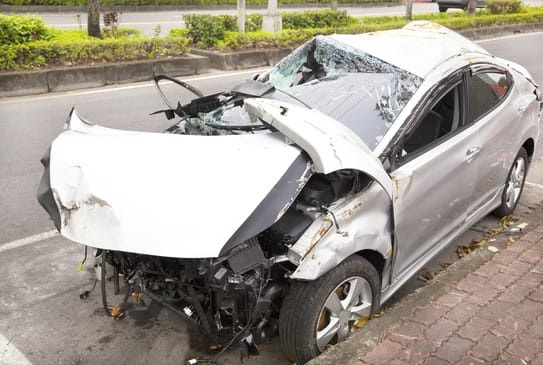

Validating that this is a picture of your car...
Car Check Passed!!!


Validating that damage exists...
Validation complete - proceeding to location and severity determination


Validating the damage area - Front, Rear or Side
Your Car is damaged at - Front Damage
Location assessment complete


Validating the Severity...
Your Car damage impact is - Severe Damage
Severity assessment complete


In [13]:
img_path = 'car_damaged3.jpg'
display(Image(filename=img_path))
engine(img_path)

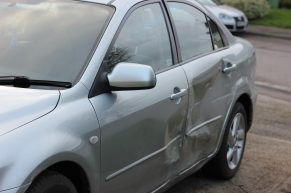

Validating that this is a picture of your car...
Car Check Passed!!!


Validating that damage exists...
Validation complete - proceeding to location and severity determination


Validating the damage area - Front, Rear or Side
Your Car is damaged at - Side Damage
Location assessment complete


Validating the Severity...
Your Car damage impact is - Moderate Damage
Severity assessment complete


In [14]:
img_path = 'car_damaged_status3.jpg'
display(Image(filename=img_path))
engine(img_path)

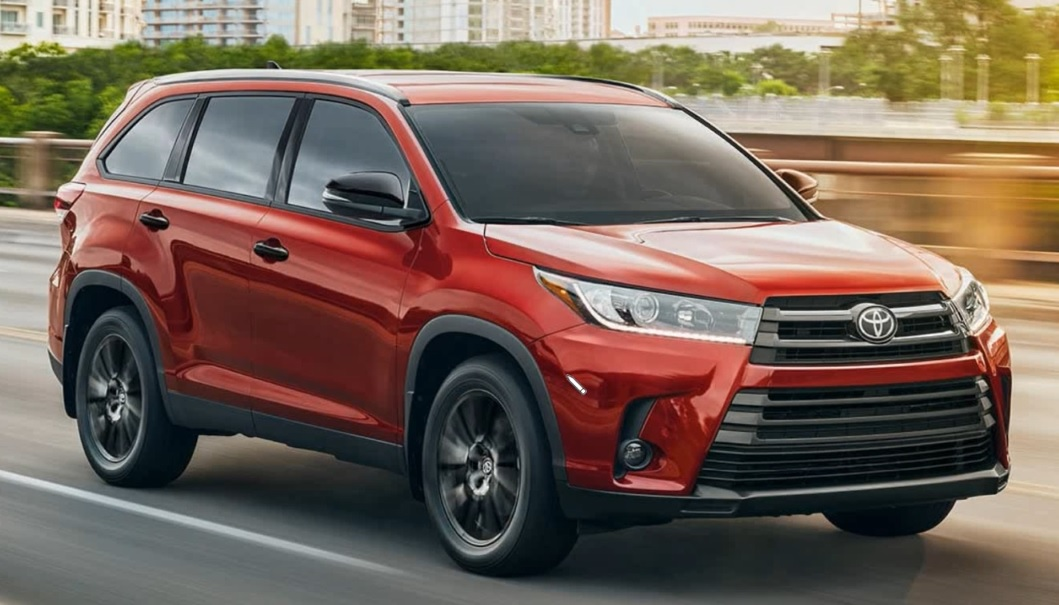

Validating that this is a picture of your car...
Car Check Passed!!!


Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting.


In [15]:
img_path = 'car2.jpg'
display(Image(filename=img_path))
engine(img_path)

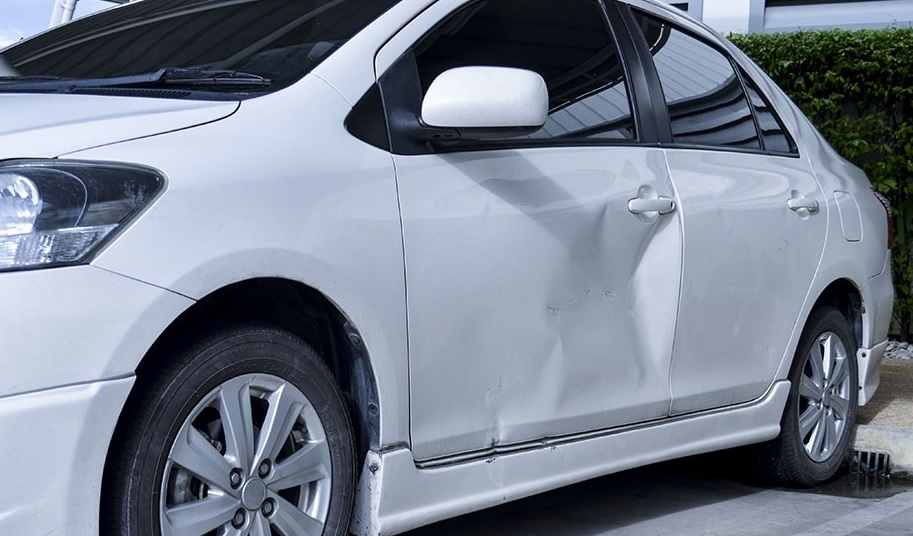

Validating that this is a picture of your car...
Car Check Passed!!!


Validating that damage exists...
Validation complete - proceeding to location and severity determination


Validating the damage area - Front, Rear or Side
Your Car is damaged at - Side Damage
Location assessment complete


Validating the Severity...
Your Car damage impact is - Moderate Damage
Severity assessment complete


In [16]:
img_path = 'car_damaged_status2.jpg'
display(Image(filename=img_path))
engine(img_path)